<a href="https://colab.research.google.com/github/VladimirBoshnjakovski/explainable-ai-thesis-code/blob/main/SHAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# ──────────────── IMPORTS ────────────────
from google.colab import files
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    log_loss,
    classification_report,
    confusion_matrix
)

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers, optimizers

import shap

In [8]:
# ──────────────── FILE UPLOAD ────────────────
uploaded = files.upload()  # Opens a file upload dialog in Colab; allows user to select a local file

# Reads the first uploaded file into a pandas DataFrame
# 'uploaded' is a dictionary where keys are filenames; 'next(iter(uploaded))' gets the first filename
df = pd.read_csv(next(iter(uploaded)))

Saving heart_hotwired.csv to heart_hotwired (1).csv


Epoch 1/100
52/52 - 3s - 52ms/step - accuracy: 0.6048 - auc: 0.6250 - loss: 0.6792 - val_accuracy: 0.7740 - val_auc: 0.8516 - val_loss: 0.6035 - learning_rate: 1.0000e-03
Epoch 2/100
52/52 - 0s - 5ms/step - accuracy: 0.7386 - auc: 0.8130 - loss: 0.5634 - val_accuracy: 0.8269 - val_auc: 0.8904 - val_loss: 0.4868 - learning_rate: 1.0000e-03
Epoch 3/100
52/52 - 0s - 5ms/step - accuracy: 0.7952 - auc: 0.8620 - loss: 0.4812 - val_accuracy: 0.8510 - val_auc: 0.9082 - val_loss: 0.4089 - learning_rate: 1.0000e-03
Epoch 4/100
52/52 - 0s - 5ms/step - accuracy: 0.8024 - auc: 0.8658 - loss: 0.4722 - val_accuracy: 0.8750 - val_auc: 0.9174 - val_loss: 0.3853 - learning_rate: 1.0000e-03
Epoch 5/100
52/52 - 0s - 6ms/step - accuracy: 0.8229 - auc: 0.8819 - loss: 0.4390 - val_accuracy: 0.8606 - val_auc: 0.9218 - val_loss: 0.3711 - learning_rate: 1.0000e-03
Epoch 6/100
52/52 - 0s - 5ms/step - accuracy: 0.8289 - auc: 0.9006 - loss: 0.4059 - val_accuracy: 0.8846 - val_auc: 0.9227 - val_loss: 0.3563 - learn

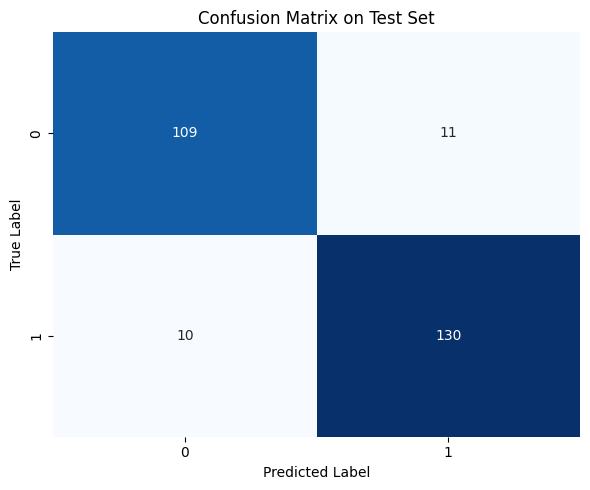

In [9]:
# ──────────────── PREPROCESS ────────────────
# assume df already loaded
df = df.drop(columns=['source']) \
       .rename(columns={'Presence of Heart Disease (1=Yes)': 'target'})

X = df.drop(columns=['target']).values
y = df['target'].values

# stratified train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# standardize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

# ──────────────── MODEL BUILDER ────────────────
def build_model(input_dim):
    l2 = regularizers.l2(1e-4)
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation='relu', kernel_regularizer=l2),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu', kernel_regularizer=l2),
        layers.Dropout(0.3),
        layers.Dense(16, activation='relu', kernel_regularizer=l2),
        layers.Dense(1, activation='sigmoid')
    ])

    # lower learning rate, track AUC
    opt = optimizers.Adam(learning_rate=1e-3)
    model.compile(
        optimizer=opt,
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model

model = build_model(X_train.shape[1])

# ──────────────── CALLBACKS ────────────────
es = callbacks.EarlyStopping(
    monitor='val_auc',      # stop when AUC stops improving
    mode='max',             # we want to MAXIMIZE AUC
    patience=10,
    restore_best_weights=True
)

rlr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-5,
    verbose=1
)

# ──────────────── TRAIN ────────────────
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=16,
    callbacks=[es, rlr],
    verbose=2
)

# ──────────────── EVALUATE ────────────────
loss, acc, auc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test loss: {loss:.4f}   |   Test accuracy: {acc:.4f}   |   Test AUC: {auc:.4f}")

# Predict on test set
y_probs = model.predict(X_test, verbose=0).flatten()
y_preds = (y_probs >= 0.5).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_preds)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on Test Set')
plt.tight_layout()
plt.show()


In [11]:
# ──────────────── SHAP GLOBAL EXPLANATION ────────────────
# Build SHAP explainer using the trained model and training data
explainer = shap.KernelExplainer(model.predict, X_train)

# Compute SHAP values for all test set instances to explain model predictions
shap_values = explainer.shap_values(X_test)

# Save SHAP values to a .npy file
np.save('shap_values.npy', shap_values)
from google.colab import files

# Download the file
files.download('shap_values.npy')

print(shap_values)  # This will give you the SHAP values for each instance and feature

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [ ]:
# ──────────────── SHAP SUMMARY PLOT (TOP 10 FEATURES) ────────────────

# Ensure SHAP values are shaped correctly and test data is in DataFrame format
# shap_values = shap_values.squeeze(-1)
# X_test_df = pd.DataFrame(X_test, columns=feature_names)

# Compute mean absolute SHAP values across all test instances
mean_abs_shap = np.abs(shap_values).mean(axis=0)

# Get indices of top 10 most important features
top_10_indices = np.argsort(mean_abs_shap)[-10:]
top_10_features = [X_test_df.columns[i] for i in top_10_indices]

# Subset SHAP values and test set to include only top 10 features
shap_values_top10 = shap_values[:, top_10_indices]
X_test_top10 = X_test_df[top_10_features]

# Plot SHAP summary plot for top 10 features
plt.figure()
shap.summary_plot(shap_values_top10, X_test_top10, show=False)
plt.title("SHAP Summary Plot \n Top 10 Most Important Features", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
# ──────────────── SHAP BAR PLOT (TOP 6 FEATURES) ────────────────

# Step 1: Compute mean absolute SHAP values across all instances
mean_abs_shap = np.abs(shap_values).mean(axis=0)

# Step 2: Create DataFrame with features and their average |SHAP| values, sorted by importance
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Mean |SHAP|': mean_abs_shap
}).sort_values(by='Mean |SHAP|', ascending=False)  # descending = most important on top

# Step 3: Select top 6 features and reverse for horizontal bar chart (lowest on top)
top_10_df = importance_df.head(6).sort_values(by='Mean |SHAP|', ascending=True)

# Step 4: Plot horizontal bar chart to show global feature importance
plt.figure(figsize=(8, 6))
plt.barh(top_10_df['Feature'], top_10_df['Mean |SHAP|'], color='skyblue')
plt.title("Top 6 Features by Mean |SHAP| \n (Global Importance)", fontsize=14, fontweight='bold')
plt.xlabel("Mean |SHAP Value|")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [ ]:
# ──────────────── SHAP BAR PLOT (SIGNED, TOP 6 FEATURES) ────────────────

# Step 1: Compute mean SHAP values across all instances (keep sign to reflect direction of impact)
mean_shap = shap_values.mean(axis=0)

# Step 2: Create DataFrame of features with their signed mean SHAP values
# Sort by absolute value to capture features with the strongest influence (positive or negative)
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Mean SHAP': mean_shap
}).sort_values(by='Mean SHAP', key=lambda x: np.abs(x), ascending=False)

# Step 3: Select top 6 features and sort by signed SHAP for clean bar plot visualization
top_6_df = importance_df.head(6).sort_values(by='Mean SHAP')

# Step 4: Plot horizontal bar chart showing both direction (sign) and magnitude of feature effects
plt.figure(figsize=(8, 6))
bars = plt.barh(
    top_6_df['Feature'],
    top_6_df['Mean SHAP'],
    color=['green' if val < 0 else 'red' for val in top_6_df['Mean SHAP']]  # green = negative impact, red = positive
)
plt.axvline(0, color='black', linewidth=0.8)  # Reference line at zero
plt.title("Top 6 Features by Mean SHAP Value \n (Direction + Magnitude)", fontsize=14, fontweight='bold')
plt.xlabel("Mean SHAP Value")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [ ]:
# ──────────────── SHAP HEATMAP (TEST SET) ────────────────

# Create a heatmap of SHAP values across all test instances
# Rows represent individual instances, columns represent features
# Color indicates the direction and magnitude of feature impact on prediction
plt.figure(figsize=(12, 8))
sns.heatmap(
    shap_values,
    xticklabels=feature_names,
    yticklabels=False,
    cmap='coolwarm',  # red = positive impact, blue = negative
    center=0           # zero-centered colormap for symmetry
)
plt.title("SHAP Heatmap: Test Set", fontsize=14, fontweight='bold')
plt.xlabel("Feature")
plt.ylabel("Instance")
plt.tight_layout()
plt.show()

In [ ]:
# ──────────────── SHAP DEPENDENCE PLOT (COLORED BY INTERACTION) ────────────────

# Set the target feature to explain and the interaction feature for coloring
target_feature = 'Maximum Heart Rate Achieved'
interaction_feature = 'Thalassemia: Reversible Defect'

# Get the column index of the target feature
feature_idx = feature_names.index(target_feature)

# Extract SHAP values for the target feature across all test instances
shap_vals = shap_values[:, feature_idx]

# Retrieve original (unscaled) feature values from the full dataset using test set indices
x_real = df.loc[X_test_df.index, target_feature].values
interaction_vals = df.loc[X_test_df.index, interaction_feature].values

# Create SHAP dependence scatter plot
plt.figure(figsize=(7, 5))
scatter = plt.scatter(
    x_real,
    shap_vals,
    c=interaction_vals,     # color by interaction feature
    cmap='coolwarm',
    s=40,
    alpha=0.8
)
cbar = plt.colorbar(scatter)
cbar.set_labe_

In [ ]:
# ──────────────── SHAP DEPENDENCE PLOT: HEART RATE × SEX ────────────────

# Define the target feature for SHAP analysis and the interaction feature for color encoding
target_feature = 'Maximum Heart Rate Achieved'
interaction_feature = 'Sex: Female'  # 0 = male, 1 = female

# Get SHAP values for the target feature across all test instances
feature_idx = feature_names.index(target_feature)
shap_vals = shap_values[:, feature_idx]

# Retrieve original (unscaled) feature values and interaction values from full dataset
x_real = df.loc[X_test_df.index, target_feature].values
interaction_vals = df.loc[X_test_df.index, interaction_feature].values  # binary: 0 = male, 1 = female

# Plot SHAP dependence scatter plot with color representing interaction feature
plt.figure(figsize=(7, 5))
scatter = plt.scatter(
    x_real,
    shap_vals,
    c=interaction_vals,
    cmap='coolwarm',  # red-blue scale for binary variable
    s=40,
    alpha=0.8
)
cbar = plt.colorbar(scatter)
cbar.set_label(interaction_feature)

# Add title and labels
plt.title("SHAP Dependence Plot: Max Heart Rate vs SHAP\n(Colored by Female = 1)", fontsize=14, fontweight='bold')
plt.xlabel("Maximum Heart Rate Achieved (Real Units)")
plt.ylabel("SHAP Value for\nMaximum Heart Rate Achieved")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# ──────────────── SHAP DEPENDENCE PLOT: SINGLE FEATURE ────────────────

# Define the target feature to analyze
feature = 'Maximum Heart Rate Achieved'
feature_index = feature_names.index(feature)

# Extract SHAP values and corresponding unscaled feature values
shap_vals = shap_values[:, feature_index]
real_vals = df.loc[X_test_df.index, feature].values

# Create scatter plot of feature value vs SHAP value
plt.figure(figsize=(7, 5))
plt.scatter(real_vals, shap_vals, color='purple', s=20, alpha=0.8)

# Add plot labels and styling
plt.xlabel(feature, fontsize=12)
plt.ylabel(f"SHAP value for\n{feature}", fontsize=12)
plt.title(f"SHAP Dependence: {feature}", fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
# ──────────────── SHAP DEPENDENCE PLOT: HEART RATE × AGE ────────────────

# Get real (unscaled) values for the target feature and interaction feature
x = df.loc[X_test_df.index, 'Maximum Heart Rate Achieved']  # X-axis: real feature values
y = shap_values[:, feature_names.index('Maximum Heart Rate Achieved')]  # Y-axis: SHAP values
interaction = df.loc[X_test_df.index, 'Age']  # Color scale: Age of each individual

# Create SHAP dependence scatter plot with age as interaction feature
plt.figure(figsize=(8, 5))
scatter = plt.scatter(x, y, c=interaction, cmap='coolwarm', s=50, alpha=0.8)
cbar = plt.colorbar(scatter)
cbar.set_label('Age')  # Colorbar label

# Add titles and axis labels
plt.title("SHAP Dependence: Max Heart Rate vs. SHAP\n(Colored by Age)", fontsize=14, fontweight='bold')
plt.xlabel("Maximum Heart Rate Achieved (Real Units)")
plt.ylabel("SHAP Value (Impact on Prediction)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
df.corr()['target'].sort_values(ascending=False)

In [ ]:
shap.summary_plot(shap_values, X_test_df)
